# Multiclass classification with Linear Regression

In [1]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import ssl
np.random.seed(42)

# Load & Transform MNIST dataset

### Download the data

In [2]:
ssl._create_default_https_context = ssl._create_unverified_context
mnist = fetch_openml('mnist_784', version=1, parser='auto')

### Data Partitioning
Split the data into training and test sets.
The training set will be used to train the model while the test
set will be used to evaluate the model's performance on unseen data.

* split - I chose to split the data into 80% training and 20% test sets (according to the task description)
* shuffle - I choose to the data before splitting it into training and test sets
* stratify - I chose to stratify the data to ensure that the training and test sets have approximately the same percentage of samples of each target class as the complete set.

In [3]:
# X is the data, y is the label
X, y = mnist['data'], mnist['target']
# Split data into train and test set with shuffle and stratify for equal distribution of labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=10000, random_state=42, shuffle=True, stratify=y)
y_train = np.array(y_train, dtype=np.int8)
y_test = np.array(y_test, dtype=np.int8)

### Data Transformation
* Flatten the images from 28x28 to 784x1 (already done while loading the data)
* Add a bias term to the data so that each sample is a 785x1 vector
* Normalization - scale the data to have zero mean and unit variance.
* One-hot encode to the labels.


In [4]:
# *The data is already flatten.

# Normalize the data to make the data less senstive to very high or very low values.
X_train = X_train / 255

# Add bias column to X_train and X_test
bias = np.ones((X_train.shape[0], 1))
X_train = np.hstack((bias, X_train))
bias = np.ones((X_test.shape[0], 1))
X_test = np.hstack((bias, X_test))


# One hot encode the labels
encoder = OneHotEncoder()
y_train = encoder.fit_transform(y_train.reshape(-1, 1)).toarray()
y_test = encoder.fit_transform(y_test.reshape(-1, 1)).toarray()

### Display the data shapes for sanity check and transparency

In [5]:
print(f'X_train shape: {X_train.shape} (type: {type(X_train[0, 0])})')
print(f'X_test shape: {X_test.shape} (type: {type(X_test[0, 0])})')
print(f'y_train shape: {y_train.shape} (type: {type(y_train[0])})')
print(f'y_test shape: {y_test.shape} (type: {type(y_test[0])})')

X_train shape: (60000, 785) (type: <class 'numpy.float64'>)
X_test shape: (10000, 785) (type: <class 'numpy.float64'>)
y_train shape: (60000, 10) (type: <class 'numpy.ndarray'>)
y_test shape: (10000, 10) (type: <class 'numpy.ndarray'>)


# The Linear Regression Model
* Linear regression is a statistical model that estimates the linear relationship between variables.
* I chose to implement 2 version of the linear regression model:
    * Closed/normal form solution - using the known formula.
    * Gradient descent - using the the gradient descent method.
* I used vectorized implementation of the linear regression model using the formula taught in class.
* I chose to initialize the weights to zero for both models.
* The in sample error for the gradient descent model is calculated using the mean squared error loss function.

In [6]:
class LinearRegression(object):
    def __init__(self, epochs: int = 0, learning_rate: float = 0.01):
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.weights = self.get_weights()
        self.labels = self.get_labels()
        self.train_loss, self.test_loss = [], []

    def fit_with_gradient_descent(self, X_train, y_train, X_test, y_test):
        '''
            Using gradient descent method to find the optimal weights.
            by minimizing the Ein loss function which is the mean squared error.
        '''
        N, N_test = X_train.shape[0], X_test.shape[0] 
        X_test = X_test / 255
        tqdm_epochs = tqdm(range(self.epochs))
        for epoch in tqdm_epochs:
            W = self.weights
            # Linear part
            Z = X_train @ W.T
            # The loss function ( mean squared error )
            Ein = np.sum(np.square(y_train - Z)) / N
            Eout = (np.sum(np.square(y_test - (X_test @ W.T)))) / N_test
            # Gradient of Ein with respect to W. gradient.shape should be d+1 X 1 (which is W.shape)
            gradient = ((Z - y_train).T @ X_train).T / N
            # Update weights
            self.weights -= self.learning_rate * gradient.T
            self.train_loss.append(Ein)
            self.test_loss.append(Eout)
            tqdm_epochs.set_description(f"Epoch: {epoch} with: Ein = {round(Ein, 5)} | Eout = {round(Eout, 5)}")

    def fit_normal_equation(self, X_train, y_train):
        '''
            Using the normal equation to find the optimal weights.
        '''
        W_optimal = np.linalg.pinv(X_train) @ y_train
        self.weights = W_optimal

    def predict(self, X):
        """
            Predict the label for each data point in X.
        """
        if self.weights.shape[0] == 10:
            self.weights = self.weights.T
        scores = X @ self.weights 
        probs = np.argmax(scores, axis=1)
        return probs
    
    def get_weights(self):
        """
            Initialize the weights with random values between -0.1 and 0.1.
        """
        # init with random vector with uniform distribution
        weights = np.zeros((10, 785))
        # weights = np.random.uniform(-0.1, 0.1, (10, 785))
        return np.array(weights)

    def get_labels(self):
        """
            Return the labels for the digits.
        """
        return [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

    def one_hot_to_digit(self, one_hot_array):
        """
            Convert one hot array to digit.
        """
        digit_list = np.argmax(one_hot_array, axis=1)
        return np.array(digit_list)

    def my_confusion_matrix(self, y, y_hats):
        """
            Calculate the:
                confusion matrix.
                accuracy for the whole test set.
                accuracy, sensitivity and selectivity for each digit.
        """
        y = self.one_hot_to_digit(y)
        confusion_mtx = confusion_matrix(y, y_hats)
        disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mtx, display_labels=self.labels)
        fig, ax = plt.subplots(figsize=(8, 8))
        disp.plot(ax=ax)
        plt.show()

        # Find true prdiction (where y == y_hats)
        TP = np.sum( y == y_hats)
        accuracy = TP / y.shape[0]
        print('Test set accuracy: ', accuracy)

        for l in self.labels:
            print(f'{l} confusion matrix & metrics:')
            y_l = np.where(y == l, 1, 0)
            y_hats_l = np.where(y_hats == l, 1, 0)

            confusion_mtx = confusion_matrix(y_l, y_hats_l)
            disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mtx, display_labels=['not ' + str(l), str(l)])
            fig, ax = plt.subplots(figsize=(4, 4))
            disp.plot(ax=ax)
            plt.show()

            # Find true positive (where y_l == 1 and y_hats_l == 1) and y_l == 1
            TP = np.sum(np.logical_and(y_l, y_hats_l))
            # Find true negative (where y_l == 0 and y_hats_l == 0) and y_l == 0
            TN = np.sum(np.logical_and(np.logical_not(y_l), np.logical_not(y_hats_l)))
            # Find false positive (where y_l == 0 and y_hats_l == 1) and y_l == 0
            FP = np.sum(np.logical_and(np.logical_not(y_l), y_hats_l))
            # Find false negative (where y_l == 1 and y_hats_l == 0) and y_l == 1
            FN = np.sum(np.logical_and(y_l, np.logical_not(y_hats_l)))

            sensitivity_TPR = TP / (TP + FN)

            print('sensitivity_TPR: ', sensitivity_TPR)

    def plot_loss_for_all_classes(self):
        """
            Plot in and out sample error of all classes in one graph.
        """
        fig, ax = plt.subplots(figsize=(10, 6))
        color = 'tab:blue'
        ax.plot(self.train_loss, label=f'Ein', color=color, linestyle='-')
        ax.plot(self.test_loss, label=f'Eout', color='tab:orange', linestyle='-')
        ax.set_xlabel('epoch')
        ax.set_ylabel('Loss')
        ax.set_title('Mean Squared Error Loss')
        ax.legend()
        plt.tight_layout()
        plt.show()
        

# Training in 2 methods
### 1. Normal equation to find the optimal weights.

In [7]:
normal_linear_regression = LinearRegression()
normal_linear_regression.fit_normal_equation(X_train, y_train)

### 2. Gradient descent method to find the optimal weights.
For the gradient descent, after trying few options for parameters, I chose the following parameters:

epochs = 200, learning_rate = 0.01

In [8]:
gradient_linear_regression = LinearRegression(epochs=200, learning_rate=0.01)
gradient_linear_regression.fit_with_gradient_descent(X_train, y_train, X_test, y_test)

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 199 with: Ein = 0.45215 | Eout = 0.45799: 100%|██████████| 200/200 [00:37<00:00,  5.38it/s]


# Evaluation for both models
* Evaluate the model's performance on the test set

* Display the confusion matrix
* Display the accuracy (TPR) for each class and the average accuracy (TPR) for all classes

### Linear Regression (Normal equation)

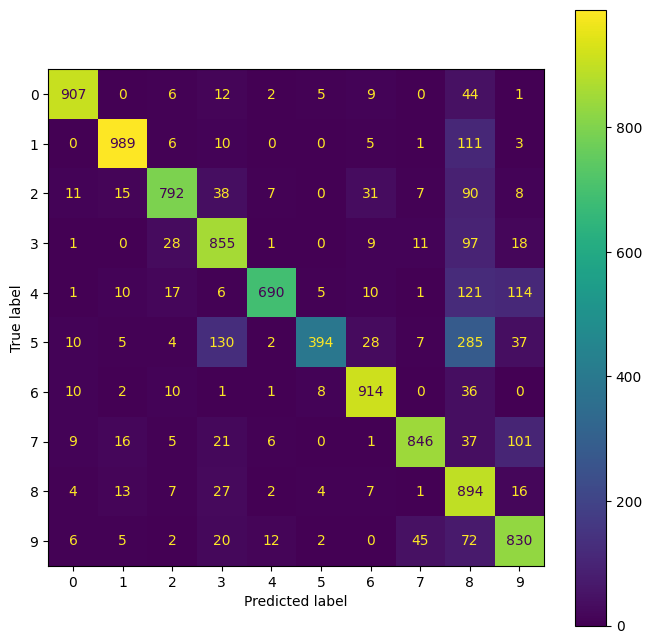

Test set accuracy:  0.8111
0 confusion matrix & metrics:


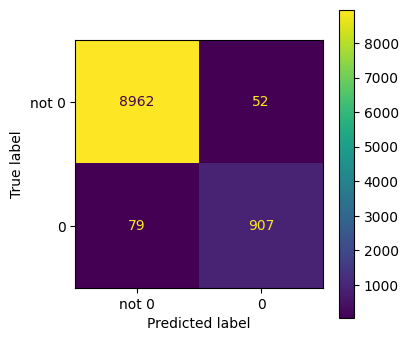

sensitivity_TPR:  0.9198782961460447
1 confusion matrix & metrics:


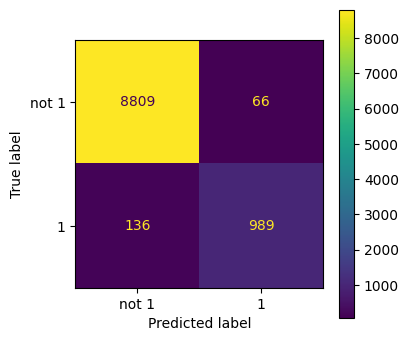

sensitivity_TPR:  0.8791111111111111
2 confusion matrix & metrics:


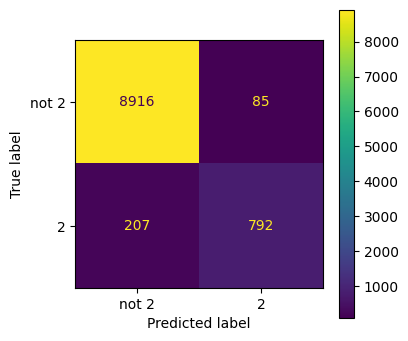

sensitivity_TPR:  0.7927927927927928
3 confusion matrix & metrics:


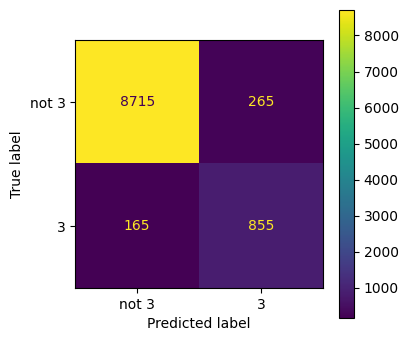

sensitivity_TPR:  0.8382352941176471
4 confusion matrix & metrics:


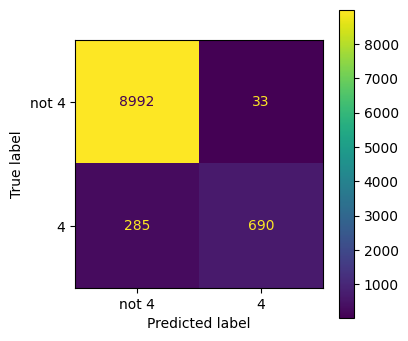

sensitivity_TPR:  0.7076923076923077
5 confusion matrix & metrics:


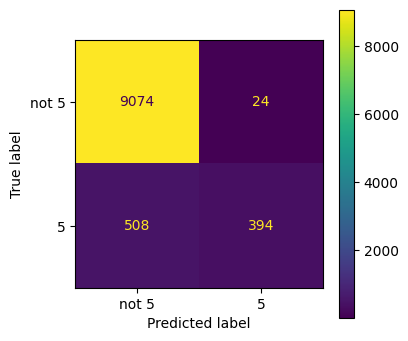

sensitivity_TPR:  0.43680709534368073
6 confusion matrix & metrics:


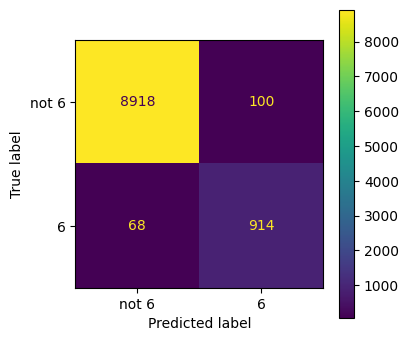

sensitivity_TPR:  0.9307535641547862
7 confusion matrix & metrics:


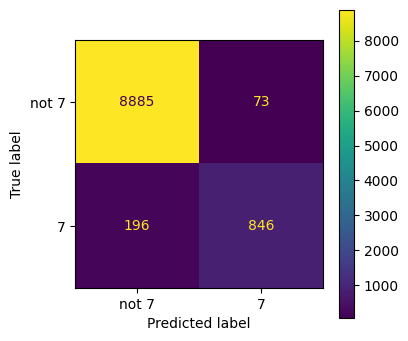

sensitivity_TPR:  0.8119001919385797
8 confusion matrix & metrics:


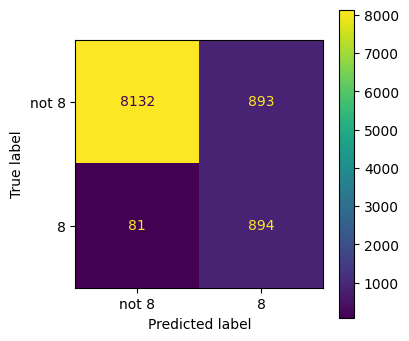

sensitivity_TPR:  0.916923076923077
9 confusion matrix & metrics:


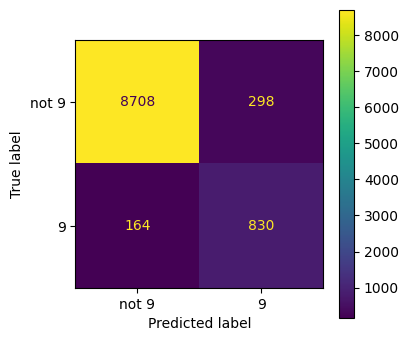

sensitivity_TPR:  0.8350100603621731


In [9]:
y_hats_linear = normal_linear_regression.predict(X_test)
normal_linear_regression.my_confusion_matrix(y_test, y_hats_linear)

## Linear Regression (Gradient descent method)

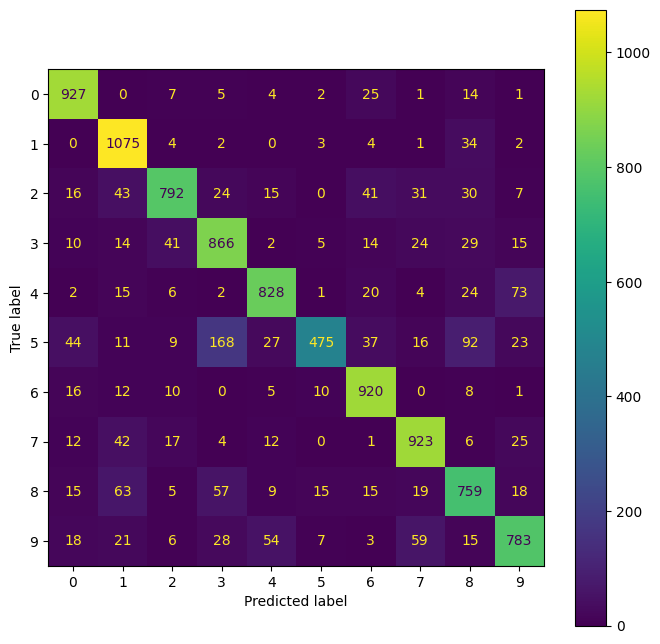

Test set accuracy:  0.8348
0 confusion matrix & metrics:


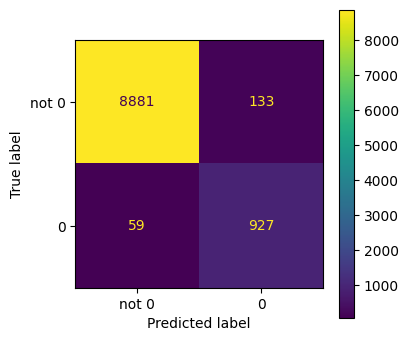

sensitivity_TPR:  0.9401622718052738
1 confusion matrix & metrics:


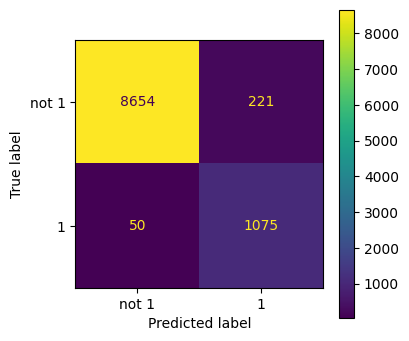

sensitivity_TPR:  0.9555555555555556
2 confusion matrix & metrics:


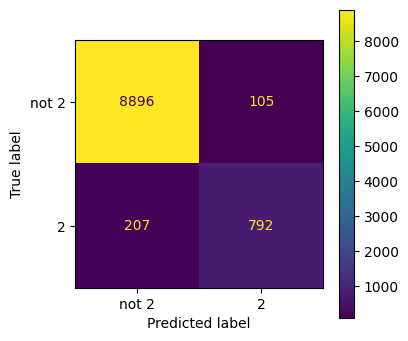

sensitivity_TPR:  0.7927927927927928
3 confusion matrix & metrics:


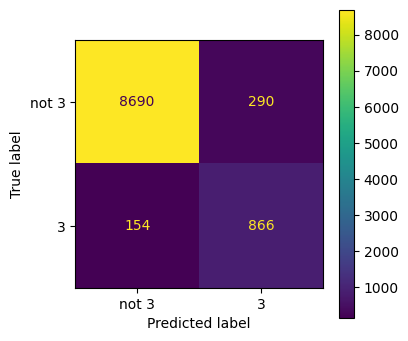

sensitivity_TPR:  0.8490196078431372
4 confusion matrix & metrics:


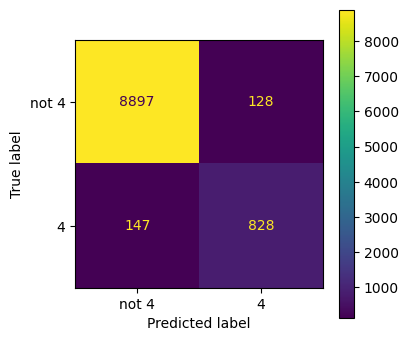

sensitivity_TPR:  0.8492307692307692
5 confusion matrix & metrics:


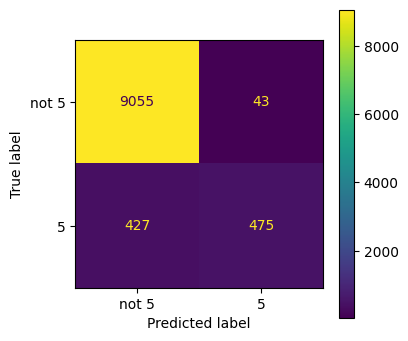

sensitivity_TPR:  0.5266075388026608
6 confusion matrix & metrics:


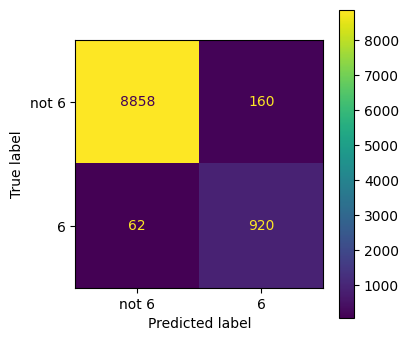

sensitivity_TPR:  0.9368635437881874
7 confusion matrix & metrics:


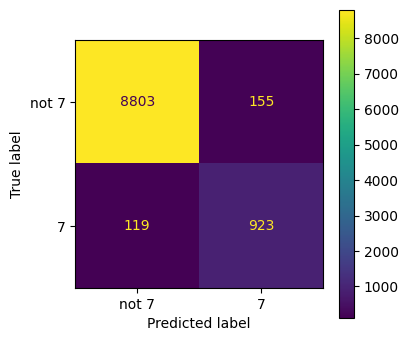

sensitivity_TPR:  0.8857965451055663
8 confusion matrix & metrics:


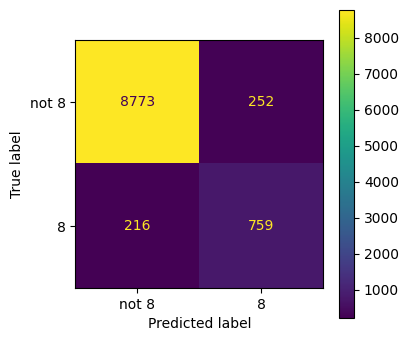

sensitivity_TPR:  0.7784615384615384
9 confusion matrix & metrics:


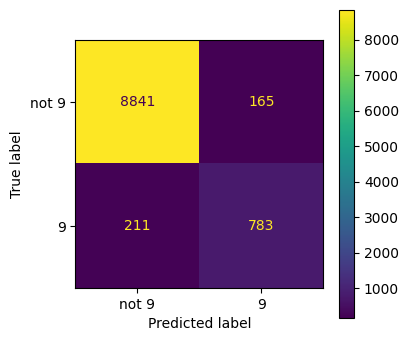

sensitivity_TPR:  0.7877263581488934


In [10]:
y_hats_gradient = gradient_linear_regression.predict(X_test)
gradient_linear_regression.my_confusion_matrix(y_test, y_hats_gradient)

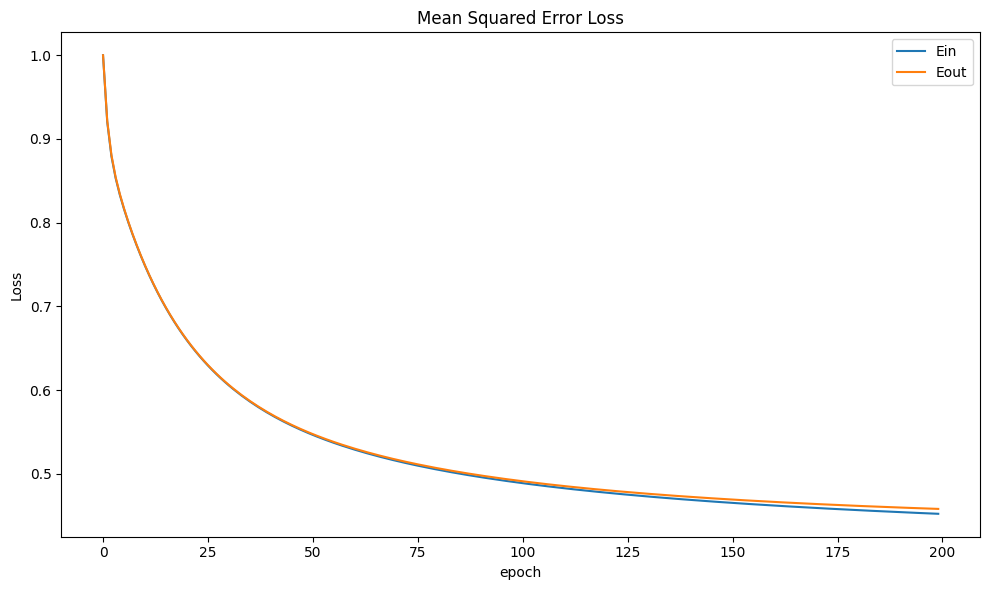

In [11]:
gradient_linear_regression.plot_loss_for_all_classes()

Also in the Linear Regression model we can see the the error line is decreasing with the number of epochs and the training error is slightly lower than the test error, as expected.

<!-- ------------------------------------ -->

# Conclusions
* I've run the gradient descent model with 200 epochs and learninng rate of 0.01 and got 0.83 accuracy.
* The normal equation model got 0.81 accuracy.
* The total time to train the model is about 1 minute. 
* Both models has low TPR for class 5. but the gradient descent model has a higher than the normal equation model (0.53 vs 0.42)
* Maybe adding more training data for the digit 5 will improve the model's performance on digit 5.
* We can see that the diagonal of the confusion matrix has the highest values, which means that the model is good at classifying the digits to their true class.

# Summary
* The accuracy of the Multi-class perceptron was 0.86.
* The accuracy of the softmax regression model was 0.89.
* The accuracy of the linear regression model got 0.83.
so the softmax regression model is the best model for this task.